### Named Entity Recognition of GUM Corpus
The purpose of this project is to analyze the Georgetown University Multilayer (**GUM**) Corpus  coming from this [repo](https://github.com/nluninja/nlp_datasets/tree/main/GUM), that contains two columns:

- token
- ner_tag

This [corpus](https://github.com/amir-zeldes/gum) contains English texts from twelve written and spoken text types:
- interviews
- news
- travel guides
- how-to guides
- academic writing
- biographies
- fiction
- online forum discussions
- spontaneous face to face conversations
- political speeches
- textbooks
- vlogs

Our goal is to classify correctly the 23 classes coming from the **ner_tag** through a **BILSTM** and **Bert Model**

### 0. Libraries

In [27]:
# Importing
import re
import urllib
import pickle
import os

# Preprocessing
import nltk
import spacy
from spacy import displacy
from math import nan
import random
import pandas as pd
import numpy as np


# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import en_core_web_sm
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS


# EDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF


# Metrics
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay


# BILSTM
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# BERT
from transformers import BertTokenizerFast,BertForTokenClassification


import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam


from Functions.importing import load_conll_data
from Functions.preprocessing import flatten_list, display_topics, remove_seq_padding, from_encode_to_literal_labels
from Functions.model import load_glove_embedding_matrix, bilstm
from Functions.plot import plot_confusion_matrix

import warnings


### 1. Importing

In [4]:
data_dir = os.path.join('/Users/gabrielecola/Github_Project/Python_project/NER_2/Named-Entity-Recognition/data')
raw_train, ner_train, output_labels = load_conll_data('gum-train.conll', dir_path=data_dir, only_tokens=True)
raw_test, ner_test, _ = load_conll_data('gum-test.conll', dir_path=data_dir, only_tokens=True)

Reading file /Users/gabrielecola/Github_Project/Python_project/NER_2/Named-Entity-Recognition/data/gum-train.conll
Read 2494 sentences
Reading file /Users/gabrielecola/Github_Project/Python_project/NER_2/Named-Entity-Recognition/data/gum-test.conll
Read 999 sentences


In [5]:
sentence_data = pd.DataFrame({'Sentence': raw_train})
sentence_data['Sentence'] = [' '.join(map(str, l)) for l in sentence_data['Sentence']]
sentence_data

,Sentence
0,"The back of my jersey says "" The Poet ' becaus..."
1,"These hotels may not be the most luxerious , b..."
2,Henga Scenic Reserve .
3,It costs us so much money to for us to travel ...
4,Tulsa has over 225 days of sunshine annually .
...,...
2489,"Come and have a look at this statue , erected ..."
2490,""" If an infant 's not getting enough iodine ....."
2491,If you cannot go to the Cuban Consulate you ma...
2492,Steps


### 2. Pre- Processing

In [6]:
train_new = flatten_list(raw_train)
ner_new = flatten_list(ner_train)
ner_data = pd.DataFrame(
    {'Word': train_new,
     'Tag': ner_new
    })
ner_data

,Word,Tag
0,The,B-object
1,back,I-object
2,of,I-object
3,my,I-object
4,jersey,I-object
...,...,...
44085,",",I-time
44086,October,I-time
44087,3,I-time
44088,",",I-time


### 3. EDA

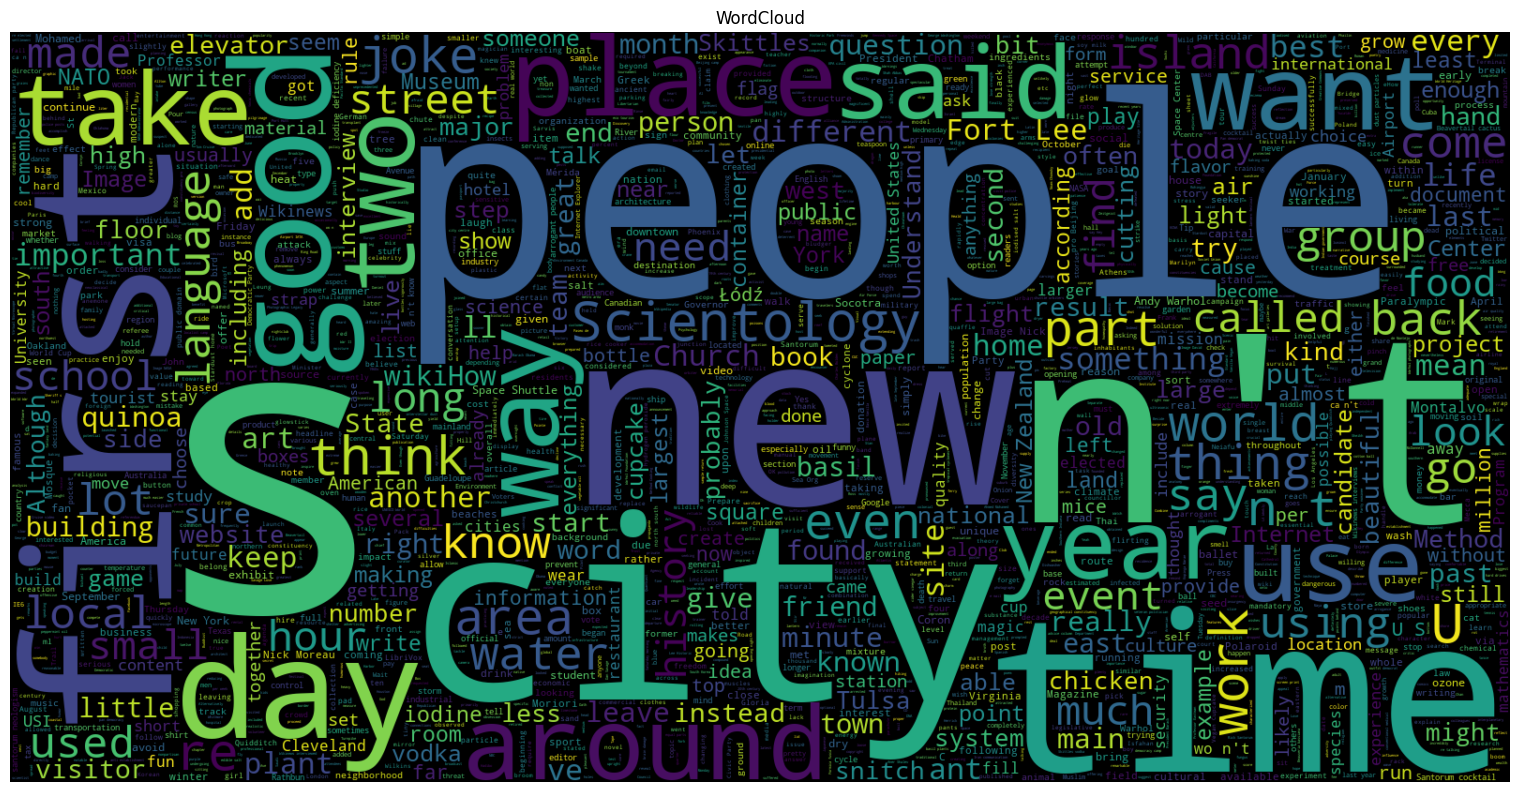

In [7]:
t= str(train_new)
testo=" ".join(train_new)
stopwords = ['many','one','will','may','see','make','well']+ list(STOPWORDS)
testo2 = WordCloud(
    background_color='black',
    max_words=2000,
    stopwords=stopwords,
    width=1600, height=800
)
# generate the word cloud
testo2.generate(testo)

# display the word cloud
plt.figure( figsize=(15,15))
plt.title('WordCloud')
plt.imshow(testo2, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
ner_data['Tag'].value_counts()

Tag
O                 20442
I-abstract         4687
I-event            2707
I-place            2212
B-abstract         2002
B-person           1919
I-person           1866
I-object           1731
B-place            1150
B-object           1016
B-event             738
I-time              663
I-organization      552
I-substance         458
B-time              401
B-organization      397
B-substance         278
I-quantity          203
I-plant             166
B-plant             144
B-animal            141
I-animal            120
B-quantity           97
Name: count, dtype: int64

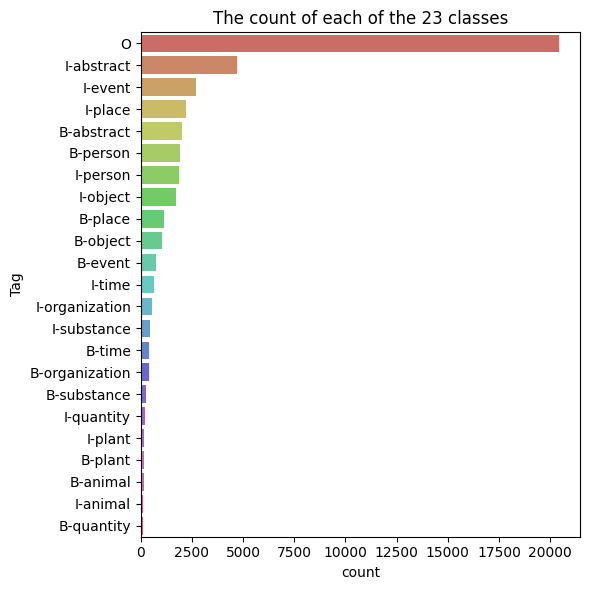

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(6, 6))

    ax = sns.countplot(
        y='Tag', 
        data=ner_data,
        order=ner_data['Tag'].value_counts().index,
        palette=sns.color_palette('hls', ner_data['Tag'].nunique())
    )

    ax.set_title('The count of each of the 23 classes')
    plt.tight_layout()
    plt.show()



### 4. Topic Modelling

#### 4.1 Pre-process the dataset

In [10]:
data_topic = pd.DataFrame({'Sentence': raw_train})
data_topic['Sentence'] = [' '.join(map(str, l)) for l in data_topic['Sentence']]
data_topic

,Sentence
0,"The back of my jersey says "" The Poet ' becaus..."
1,"These hotels may not be the most luxerious , b..."
2,Henga Scenic Reserve .
3,It costs us so much money to for us to travel ...
4,Tulsa has over 225 days of sunshine annually .
...,...
2489,"Come and have a look at this statue , erected ..."
2490,""" If an infant 's not getting enough iodine ....."
2491,If you cannot go to the Cuban Consulate you ma...
2492,Steps


In [11]:
# CountVectorizer is used to convert a collection of text documents to a matrix of token counts
# The result is a sparse matrix where each row corresponds to a document and each column corresponds to a token
# The value in each cell is the count of the token in the document
cv = CountVectorizer(stop_words='english')
dtm = cv.fit_transform(data_topic['Sentence'])
dtm_feature_names = cv.get_feature_names_out()

#### 4.2 LDA

 <img src="https://user-images.githubusercontent.com/103529789/207368819-1f391c80-ee6c-44e3-ba38-841634a5522f.PNG" width="700"/>



LDA used for **Topic Modeling**, it is a generative **probabilistic** model that assumes each **document** is a mixture of **topics** and each topic is a mixture of words. \
The model learns the topics from the data and can be used to infer the topic distribution of new documents. \
Furthermore The model is trained using the Expectation-Maximization algorithm





In [12]:
LDA = LatentDirichletAllocation(n_components=12,random_state=42) # The number of topics is a hyperparameter that needs to be set before training the model
LDA.fit(dtm)

,n_components,12
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [24]:
topic_results = LDA.transform(dtm)
topic_results.shape
argmax = topic_results.argmax(axis=1)
argmax = list(argmax)

data_topic['Topic'] = argmax
data_topic.head()

,Sentence,Topic
0,"The back of my jersey says "" The Poet ' becaus...",6
1,"These hotels may not be the most luxerious , b...",8
2,Henga Scenic Reserve .,4
3,It costs us so much money to for us to travel ...,8
4,Tulsa has over 225 days of sunshine annually .,2


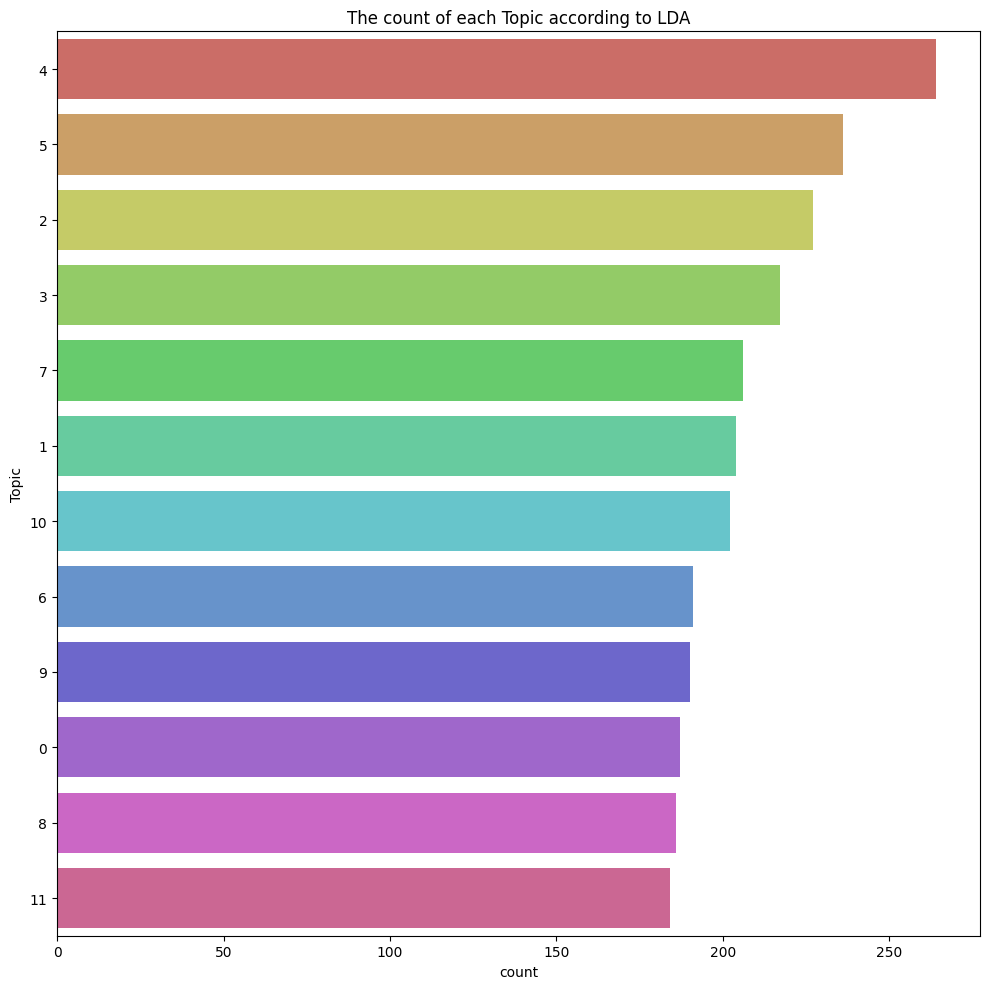

In [ ]:
# Get the sorted order of topics by frequency
ordered_topics = data_topic['Topic'].value_counts().index

# Suppress known warnings (like FutureWarning, DeprecationWarning, etc.)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(6, 6))

    sns.countplot(
        y='Topic', 
        data=data_topic, 
        order=ordered_topics,
        palette=sns.color_palette('hls', data_topic['Topic'].nunique())
    ).set(title='The count of each Topic according to LDA')

    plt.tight_layout()
    plt.show()



### 5. Feature Engineering

#### 5.1 Token Ordinal Encoding

An ordinal encoding involves mapping each unique label to an integer value.

In [13]:
# integer encode sequences of words
token_tokenizer = Tokenizer()    # Automatically lowers tokens
token_tokenizer.fit_on_texts(raw_train + raw_test)
# Save the tokenizer
with open('/Users/gabrielecola/Github_Project/Python_project/NER_2/tokenizer.pkl', 'wb') as file:
    pickle.dump(token_tokenizer, file)

train_sequences = token_tokenizer.texts_to_sequences(raw_train)
test_sequences = token_tokenizer.texts_to_sequences(raw_test)

tag2idx = { tag: idx for idx, tag in enumerate(output_labels) }
idx2tag = { idx: tag for tag, idx in tag2idx.items() }
ner_train_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_train]
ner_test_sequences  = [[tag2idx[tag] for tag in sentence] for sentence in ner_test ]

vocabulary_size = len(token_tokenizer.word_counts)

In [14]:
print(raw_test[5])
print(test_sequences[5])
for i in test_sequences[5]:
    print(f'{i} : {token_tokenizer.index_word[i]}')

['If', 'Keeper', 'is', 'close', 'to', 'their', 'hoops', 'they', 'are', 'safe', 'from', 'being', 'hit', 'by', 'bludgers', '.']
[36, 4116, 9, 489, 6, 57, 2583, 32, 18, 855, 21, 170, 767, 31, 1024, 2]
36 : if
4116 : keeper
9 : is
489 : close
6 : to
57 : their
2583 : hoops
32 : they
18 : are
855 : safe
21 : from
170 : being
767 : hit
31 : by
1024 : bludgers
2 : .


#### 5.2 Sequence Padding

To fit the data into any neural network, we need to convert the data into sequence matrices. For this, we are using the **pad_sequence**, that is also used to ensure that all sequences in a list have the same length

In [15]:
# if you want to specify the maximum length of each sequence you can use the maxlen argument. This will truncate all sequences longer than maxlen.
max_sequence_len = 50
X_train = pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post', truncating='post')

Y_train = pad_sequences(ner_train_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_test = pad_sequences(ner_test_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')

Y_train = to_categorical(Y_train, num_classes=len(output_labels))#, dtype='int32')
Y_test = to_categorical(Y_test, num_classes=len(output_labels))#, dtype='int32')

#### 5.3 Train/Test Split

In [16]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [17]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2494, 50)
(2494, 50, 23)
(999, 50)
(999, 50, 23)


### 6. Model: BILSTM

 <img src="https://user-images.githubusercontent.com/103529789/208704358-485ff377-7c76-4078-a153-30da999fac36.JPG" width="800"/>

#### 6.1 Glove: Word Embedding

**Word embeddings**  are a class of approaches for representing words and documents using a dense vector representation. \
It is an improvement over more the traditional **bag-of-word** model encoding schemes.

**How does it works?** \
Keras supports word embeddings via the Embedding layer. \
The Embedding layer is initialized with **random weights** and will learn an embedding for all of the words in the training dataset, but it can be also use a **word embedding learned elsewhere**. 


It is common in the field of Natural Language Processing to learn, save, and make freely available word embeddings. \
In this case there is a pre-trained word embeddings on the  [website](https://nlp.stanford.edu/projects/glove/) of researchers behind **GloVe** method  and dowload the smallest package of embeddings is 822Mb, called “**glove.6B.zip**“. \
It was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words.

In [18]:
USE_GLOVE=True
glove_matrix=None
if USE_GLOVE:
    glove_embedding_path = '/Users/gabrielecola/Github_Project/Python_project/NER_2/glove.6B/glove.6B.100d.txt'
    embedding_dim = 100
    glove_matrix = load_glove_embedding_matrix(glove_embedding_path, token_tokenizer.word_index, embedding_dim)

Found 400000 word vectors.


In [32]:
model= bilstm(vocabulary_size+1, # vocabulary size + 1 for padding,
              max_sequence_len, # maximum length of the sequences
              drop=0.6, # dropout rate
              hidden_cells=200, # number of hidden cells
              n_classes= len(output_labels),
              use_glove=USE_GLOVE,
              glove_matrix=glove_matrix)


es=EarlyStopping(monitor='loss',patience=2,mode="auto")
history = model.fit(X_train, Y_train, batch_size=10, epochs=100, verbose=2, callbacks=[es])
model.save("bilstm_model.keras")

/Users/gabrielecola/anaconda3/envs/NER/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       871,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,500 (3.32 MB)

 Trainable params: 871,500 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
250/250 - 24s - 96ms/step - accuracy: 0.8088 - loss: 0.7651 - precision_2: 0.9224 - recall_2: 0.7277
Epoch 2/100
250/250 - 24s - 95ms/step - accuracy: 0.8279 - loss: 0.6001 - precision_2: 0.9477 - recall_2: 0.7698
Epoch 3/100
250/250 - 23s - 90ms/step - accuracy: 0.8388 - loss: 0.5497 - precision_2: 0.9491 - recall_2: 0.7831
Epoch 4/100
250/250 - 20s - 78ms/step - accuracy: 0.8451 - loss: 0.5263 - precision_2: 0.9492 - recall_2: 0.7896
Epoch 5/100
250/250 - 18s - 74ms/step - accuracy: 0.8507 - loss: 0.5024 - precision_2: 0.9501 - recall_2: 0.7965
Epoch 6/100
250/250 - 20s - 79ms/step - accuracy: 0.8557 - loss: 0.4808 - precision_2: 0.9504 - recall_2: 0.8036
Epoch 7/100
250/250 - 24s - 96ms/step - accuracy: 0.8591 - loss: 0.4662 - precision_2: 0.9498 - recall_2: 0.8079
Epoch 8/100
250/250 - 23s - 93ms/step - accuracy: 0.8631 - loss: 0.4533 - precision_2: 0.9483 - recall_2: 0.8134
Epoch 9/100
250/250 - 25s - 99ms/step - accuracy: 0.8654 - loss: 0.4419 - precision_2: 0.9495 - 

#### 6.2 Plot Accuracy vs Loss

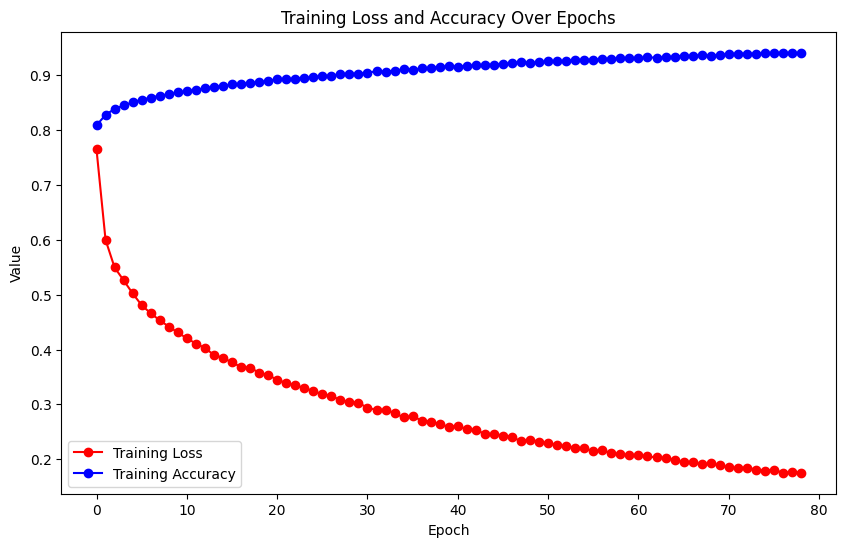

In [33]:
# Extract loss and accuracy
loss = history.history['loss']
accuracy = history.history['accuracy']

# (Optional) validation data
val_loss = history.history.get('val_loss')
val_accuracy = history.history.get('val_accuracy')

# Create the figure
plt.figure(figsize=(10,6))

# Plot Loss
plt.plot(loss, label='Training Loss', color='red', marker='o')
if val_loss:
    plt.plot(val_loss, label='Validation Loss', color='orange', marker='x')

# Plot Accuracy
plt.plot(accuracy, label='Training Accuracy', color='blue', marker='o')
if val_accuracy:
    plt.plot(val_accuracy, label='Validation Accuracy', color='green', marker='x')

# Titles and labels
plt.title('Training Loss and Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


In [34]:
batch_size = 10
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test)]
for title, X, Y in datasets:
    # we make predictions
    Y_pred_lstm = model.predict(X, batch_size=batch_size)
    Y_pred_lstm = np.array(np.argmax(Y_pred_lstm, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred_lstm)
    let_y_true_lstm, let_y_pred_lstm = from_encode_to_literal_labels(Y, Y_pred_lstm, idx2tag)
    # from a double list we make a single list according to the argument of classification report
    single_list_true_lstm = []
    single_list_pred_lstm = []
    for i in range(len(let_y_true_lstm)):
      for j in range(len(let_y_true_lstm[i])):
        single_list_true_lstm.append(let_y_true_lstm[i][j])
    for i in range(len(let_y_pred_lstm)):
      for j in range(len(let_y_pred_lstm[i])):
       single_list_pred_lstm.append(let_y_pred_lstm[i][j])
    print(title)
    print(classification_report(single_list_pred_lstm, single_list_true_lstm))

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
Training Set
                precision    recall  f1-score   support

    B-abstract       0.83      0.83      0.83      1982
      B-animal       0.81      0.84      0.83       134
       B-event       0.67      0.82      0.74       602
      B-object       0.86      0.91      0.88       959
B-organization       0.80      0.94      0.86       339
      B-person       0.97      0.88      0.92      2086
       B-place       0.90      0.87      0.89      1184
       B-plant       0.94      0.88      0.91       153
    B-quantity       0.87      0.84      0.85       100
   B-substance       0.88      0.84      0.86       289
        B-time       0.92      0.82      0.87       449
    I-abstract       0.86      0.96      0.90      4151
      I-animal       0.99      0.80      0.88       148
       I-event       0.85      0.98      0.91      2331
      I-object       0.95      0.93      0.94      1754
I-organization       0.94      0.94      0.94   

#### 6.3 Confusion Matrix

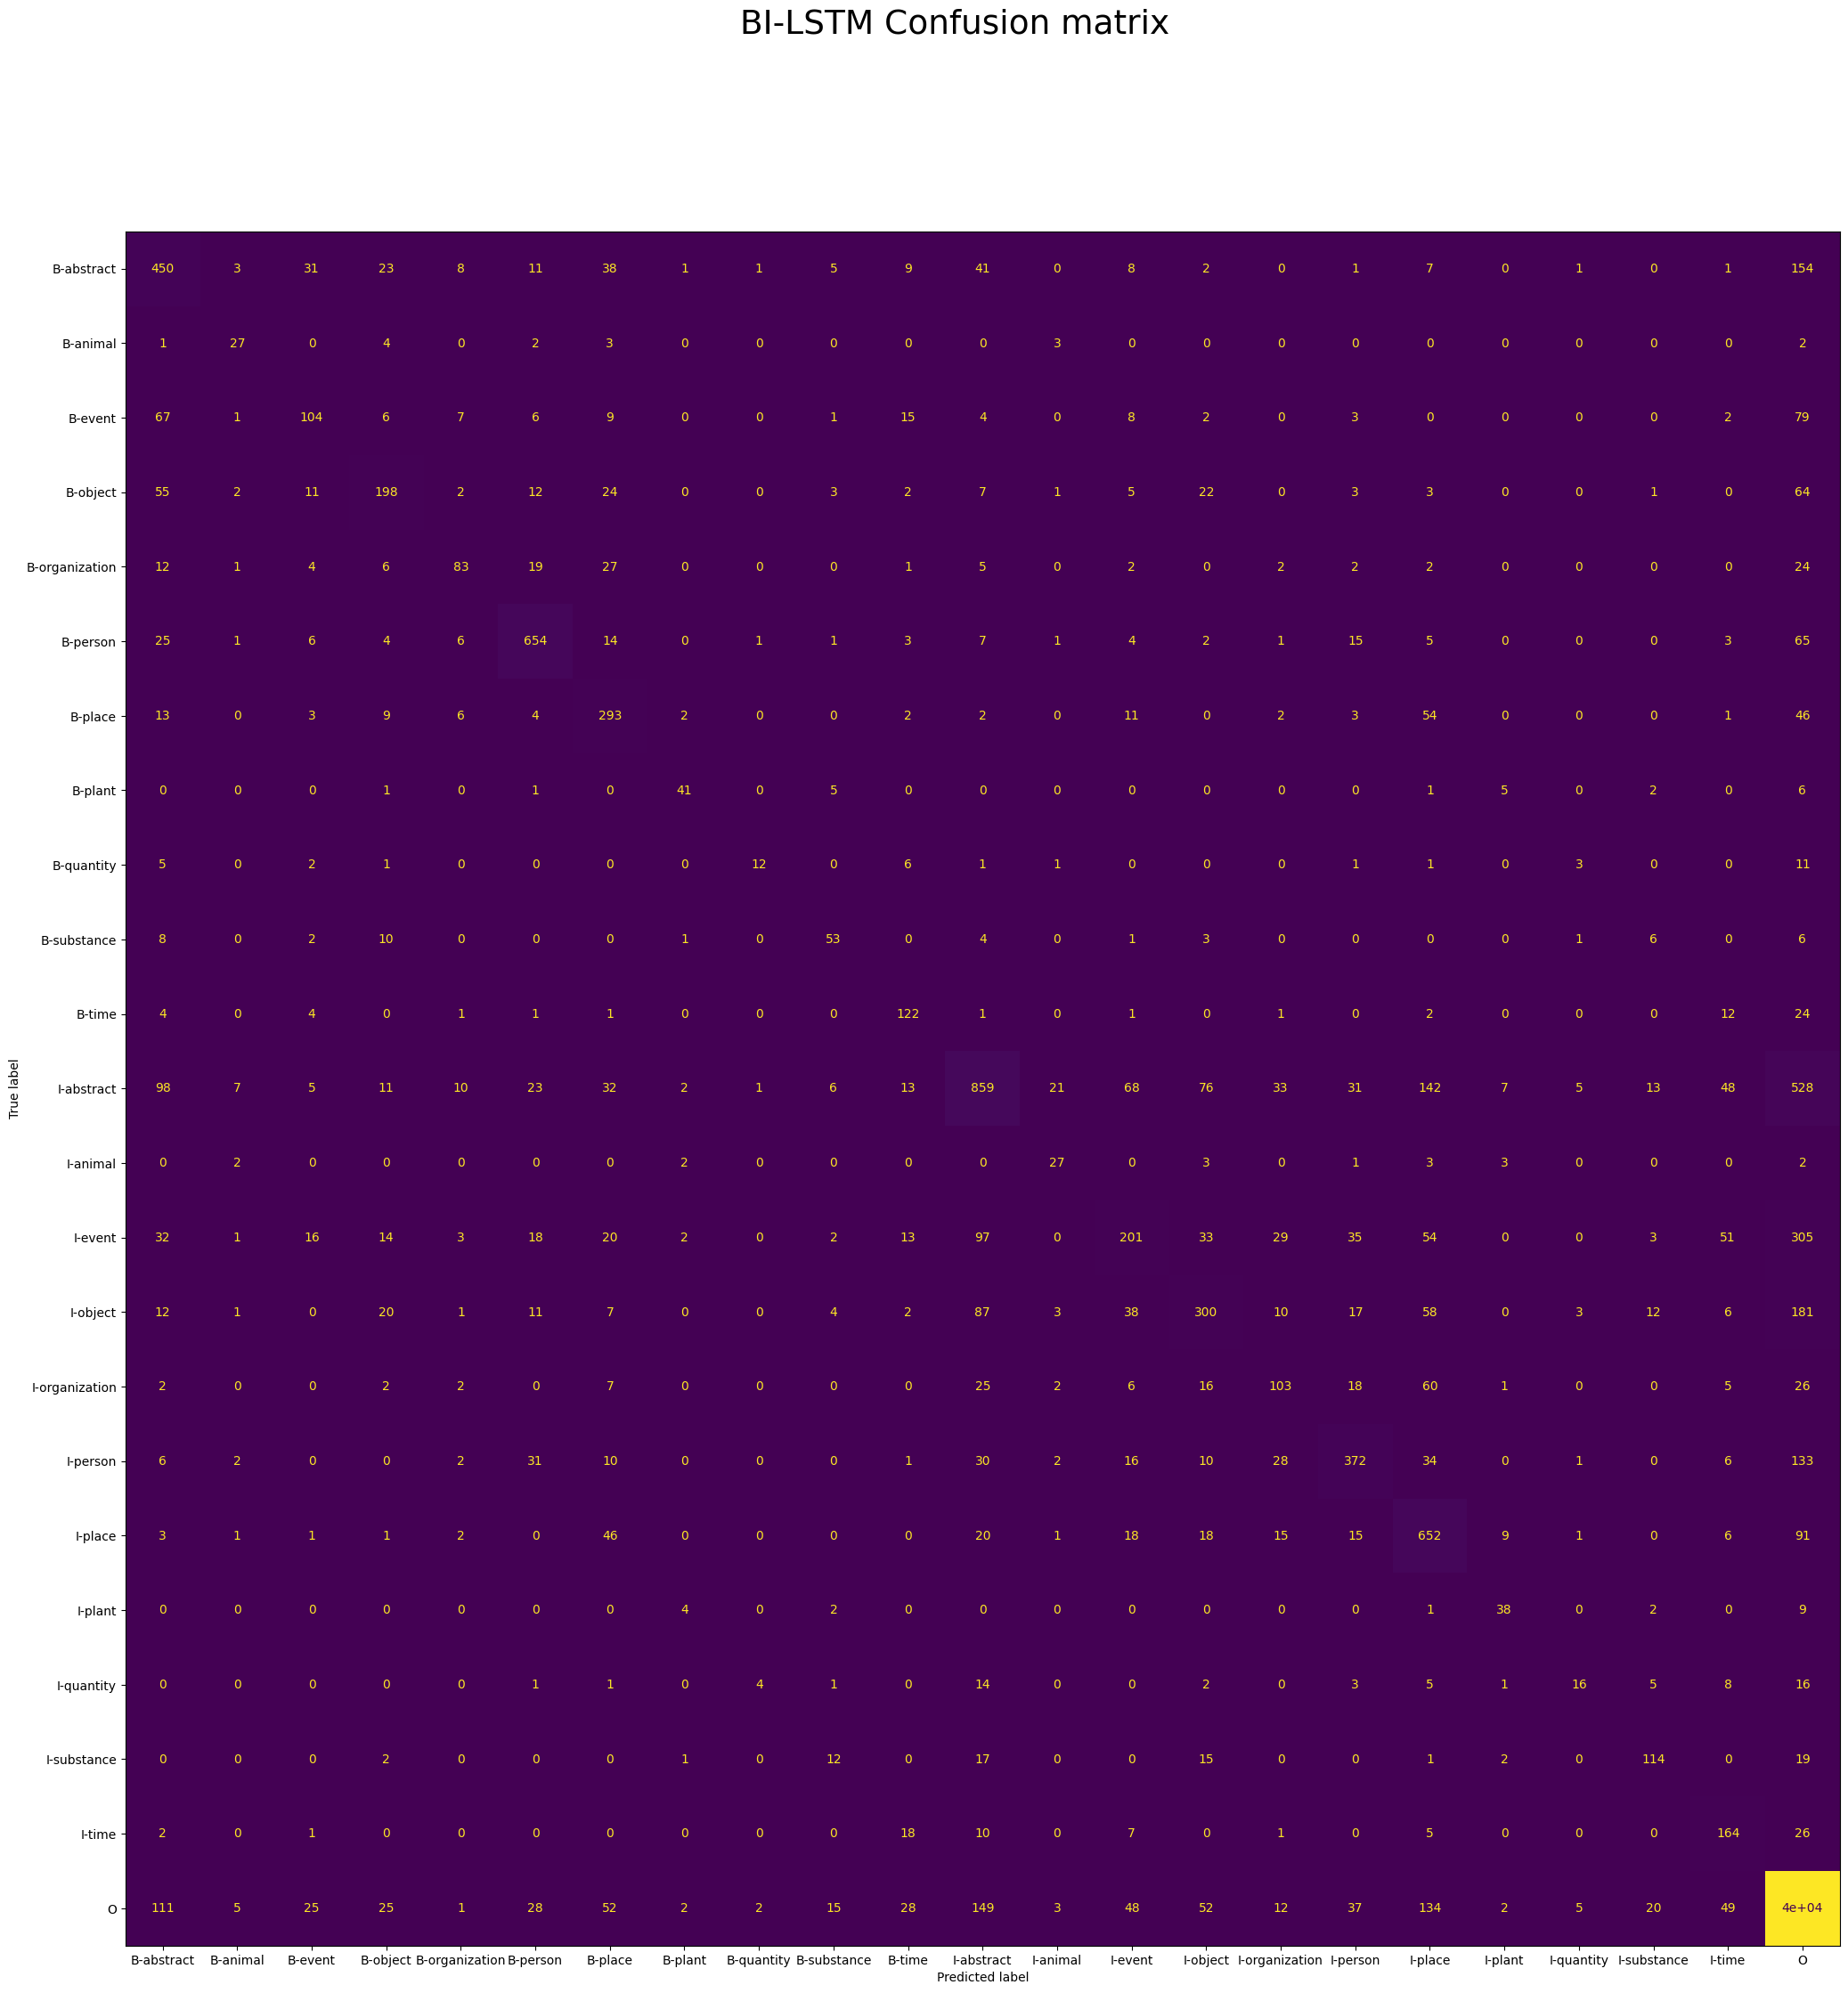

In [35]:
classes= ['B-abstract','B-animal','B-event','B-object','B-organization','B-person','B-place','B-plant','B-quantity',
          'B-substance','B-time','I-abstract','I-animal','I-event','I-object','I-organization','I-person','I-place',
          'I-plant','I-quantity','I-substance','I-time','O']


# calculated on test set
plot_confusion_matrix(single_list_pred_lstm, single_list_true_lstm, classes)